<p align="center">
  <img width="300" height="300" src="https://www.linkpicture.com/q/VISTRKR_Logo1.png">
</p>

## Modules

In [1]:
import numpy as np
import math
import sys

main_path = r"C:\Users\97254\OneDrive - Technion\Technion\09 Semester G\084653\Semester B\Week 01\pythonProject"
sys.path.insert(1, main_path)

# Import functions from different modules
from calibration import calib_functions
from estimation import estim_functions
from simulation import sim_functions

from main import calibrate_cameras, estimate_position, simulate_data

from data.general import *

## Data Analysis

In [2]:
# Define a lambda function foo(x)
foo = lambda x: 1.5 * np.cos(x / 2) - x + 16
# foo = lambda x: 0.1 * x**2

# Generate points using the sim_functions module
p = sim_functions.generate_2d_points(foo, x_range=[2, 18], y_range=[2, 18], density=10)

# Simulate measurements using the cameras_data and generated points
measurements = simulate_data(cameras_data, p, noise_std=25)

# Estimate the position of the points using cameras_data and measurements
points = estimate_position(cameras_data, measurements)

## Visualization

<IPython.core.display.Javascript object>


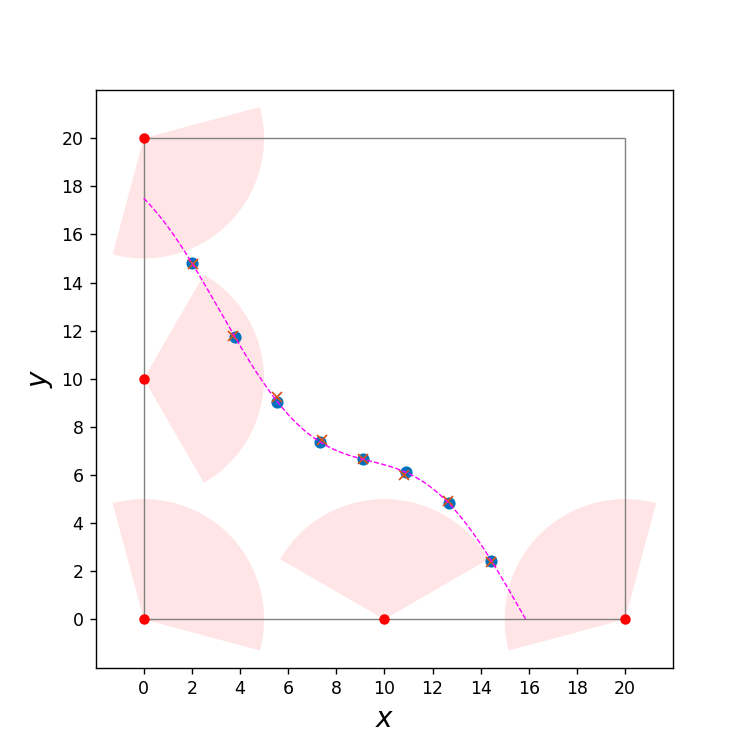

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from visualization.vis_functions import plot_filled_sector

%matplotlib notebook
X = np.linspace(0, 20, 500)
Y = foo(X)
mask = (0<=X) & (X<=20) & (0<=Y) & (Y<=20)
p = np.array(p)

fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

ax.plot(p[:, 0], p[:, 1], 'o', c='#0072BD')
ax.plot(points[:, 0], points[:, 1], 'x', c='#D95319')
# ax.plot(result[:, 0], result[:, 1], '*', c='#7E2F8E')
ax.plot(X[mask], Y[mask], lw=.8, ls='--', c='#FF00FF')

for camera in cameras_data:
    plot_filled_sector(camera['position'], camera['azimuth'], 5, 120, ax, sector_color=[1, 0, 0, .1])
    
ax.hlines([0, 20], 0, 20, colors='grey', lw=.8)
ax.vlines([0, 20], 0, 20, colors='grey', lw=.8)


ax.set_xticks(np.arange(0, 21, 2)) ; ax.set_yticks(np.arange(0, 21, 2))
ax.set_xlim([-2, 22]) ; ax.set_ylim([-2, 22])
ax.set_xlabel('$x$', size=16) ; ax.set_ylabel('$y$', size=16)
# ax.grid()
plt.show()